# Import necessary modules

In [1]:
# Modules to ignore warnings
import warnings               
warnings.filterwarnings('ignore')

# import tensorflow as tf
# tf.logging.set_verbosity(tf.logging.ERROR)

import os   
import shutil
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from subprocess import call

In [8]:
from keras.models import Sequential, Model, load_model
from keras.layers import *
from keras.optimizers import Adam, SGD
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.utils import to_categorical

# Reading Data

In [3]:
# Dictionary: key - folder name, value - Category
class_map = {'c0': 'safe driving',
            'c1': 'texting - right',
            'c2': 'talking on the phone - right',
            'c3': 'texting - left',
            'c4': 'talking on the phone - left',
            'c5': 'operating the radio',
            'c6': 'drinking',
            'c7': 'reaching behind',
            'c8': 'hair and makeup',
            'c9': 'talking to passenger'}

In [4]:
train_path = '/home/datasets/cse_7321c/distracted_driver/train/'   # Train data path
val_path = '/home/datasets/cse_7321c/distracted_driver/val/'       # Validation data path
classes = os.listdir(train_path)                                   # List of directories in train path
print(classes)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


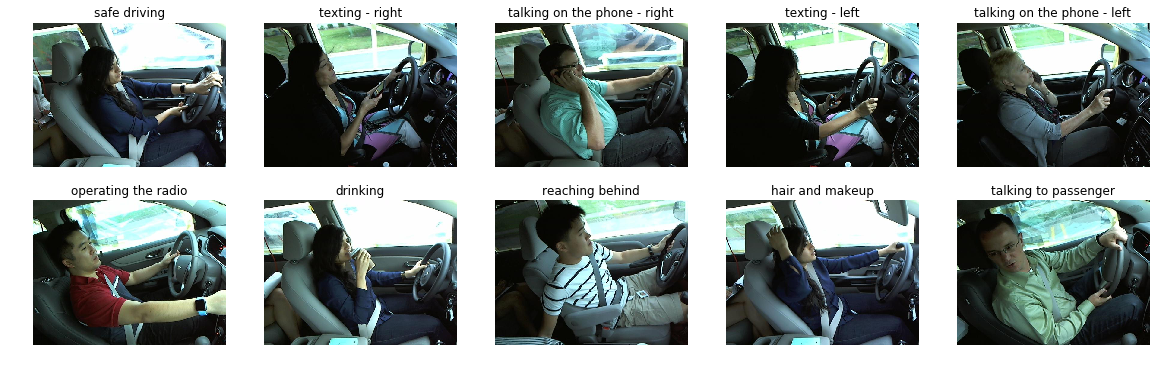

In [5]:
# Plot a sample image from each category

plt.figure(figsize=(20,6))
for ix,i in enumerate(classes):
    f = os.listdir(os.path.join(train_path,i))[0]
    img = mpimg.imread(os.path.join(train_path,i,f))
    plt.subplot(2,5,ix+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(class_map[i])

# Image Augmentation

In [24]:
images_count = 0
for i in range(0,10):
    images = len(os.listdir(train_path+'c'+str(i)))
    images_count = images_count+images
images_count

18381

In [25]:
# Import ImageDataGenerator for image preprocessing/augmentation
# This basically creates multiple copies of train images by jittering(adding noise). 
# This includes rotating, zooming in, flipping, shifting, etc.

datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest') # 'nearest' is kind of algorithm to fill pixel values while transformation

In [26]:
aug_images_path = 'preview'
f = os.listdir(os.path.join(train_path,classes[5]))[0]
img_path = os.path.join(train_path,classes[5],f)
img = load_img(img_path)       # this is a PIL image
x = img_to_array(img)          # this is a Numpy array with shape (480, 640, 3)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 480, 640, 3)

# Create a directory named 'preview' to save augmented images. 
# Delete, if already exists
if os.path.isdir(aug_images_path):
#     os.system('rm -rf '+aug_images_path)
    shutil.rmtree(aug_images_path)
    
os.system('mkdir '+aug_images_path)
    
# the .flow() command below generates augmented images and saves them to a directory names 'preview'
i = 0
for batch in datagen.flow(x, batch_size=1, save_to_dir=aug_images_path, save_prefix='c4', save_format='jpg'):
    i += 1
    if i > 9:
        break  # otherwise the generator would loop indefinitely

Text(0.5,1,'Original Image: img_10000.jpg')

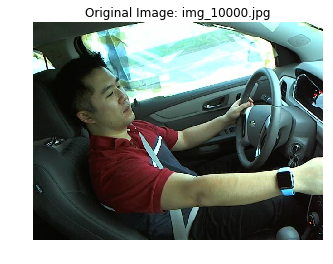

In [27]:
plt.imshow(img)
plt.axis('off')
plt.title('Original Image: '+f)

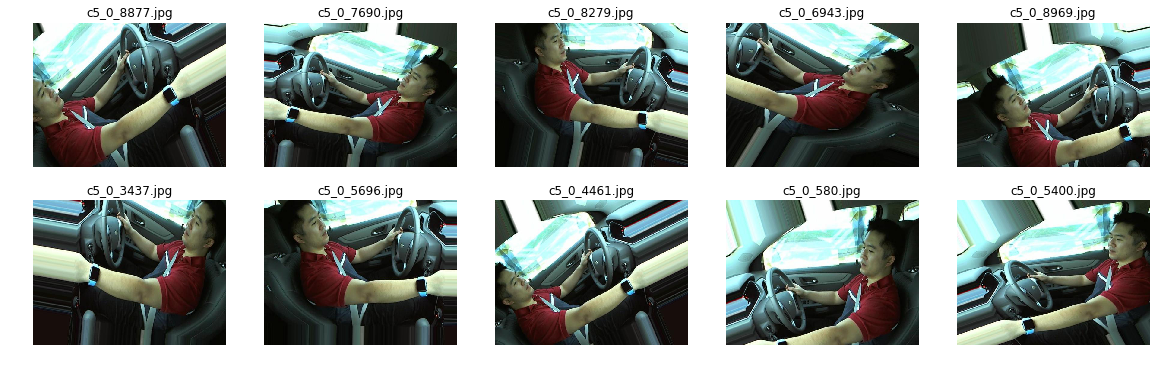

In [28]:
# Plot the augmented images for the above original image
# Read them from 'preview' directory and display them

plt.figure(figsize=(20,6))
aug_images = os.listdir('preview')
for ix,i in enumerate(aug_images):
    img = mpimg.imread(os.path.join('preview',i))
    plt.subplot(2,5,ix+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)
    if ix==10:
        break

In [29]:
os.listdir('preview')

['c5_0_8877.jpg',
 'c5_0_7690.jpg',
 'c5_0_8279.jpg',
 'c5_0_6943.jpg',
 'c5_0_8969.jpg',
 'c5_0_3437.jpg',
 'c5_0_5696.jpg',
 'c5_0_4461.jpg',
 'c5_0_580.jpg',
 'c5_0_5400.jpg']

# Data Generator

In [30]:
# This is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rescale=1/255.,
                                    rotation_range=20,
                                    height_shift_range=0.2,
                                    zoom_range=0.2)

# This is a generator that will read pictures found in subfolers of 'train', and generates
# batches of augmented image data on the fly
train_generator = train_datagen.flow_from_directory(directory=train_path, 
                                                    batch_size=64, 
                                                    class_mode='categorical', 
                                                    shuffle=True, 
                                                    target_size=(224,224))

Found 18381 images belonging to 10 classes.


In [31]:
# This is the augmentation configuration we will use for validation
val_datagen = ImageDataGenerator(rescale=1/255.)
val_generator = train_datagen.flow_from_directory(directory=val_path, 
                                                    batch_size=64, 
                                                    class_mode='categorical', 
                                                    shuffle=False, 
                                                    target_size=(224,224))

Found 4043 images belonging to 10 classes.


# CNN for Image Classification

In [32]:
# Sequential is a container in keras which is used to stack layers in order
# First layer should include the input data shape. This is mandatory. 
# Padding valid implies no padding
# Padding SAME implies enough padding so that output has the same dimensions as input 
# Initial layers identify fewer basic features like edges while later layers identify a lot of more abstract features. 
# Therefore, no. of filters increase as we go deeper into the network. 
# Batchormalization is standard in convolution layers. Improves the convergence time.
# Activation is applied after the Batch normalization
# Dropout could be used for regularization in the fully-connected part of the network

def image_classifier(nb_classes):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(5, 5), input_shape=(224, 224, 3), padding='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=128, kernel_size=(5, 5), padding='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dropout(0.2))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))

    model.add(Dense(nb_classes, activation='softmax'))
    
    return(model)

In [33]:
# Cross Entropy is the standard loss function for classification tasks. 
# Adam is the most popular optimizer. Convergence is quick. Could be unstable sometimes. 
# Learning Rate Schedulers could be used for stabilizing training process
# The 'metrics' mentioned will be computed during run time. So that we can monitor the progress.

model = image_classifier(nb_classes=10)
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [ ]:
hist0 = model.fit_generator(train_generator,
                           validation_data=val_generator,
                           epochs=10,
                           steps_per_epoch=18381/64,validation_steps=4043/64,).history

Epoch 1/10
121/287 [===========>..................] - ETA: 2:27 - loss: 12.6281 - acc: 0.1028

# Transfer Learning

In [119]:
# Inception was trained on 299x299x3 size images. Therefore we'll use the same dimentions for out task.
# Nevertheless, in transfer learning, if we are importing only the convolution layers, we can resize the images to other resolutions as well
# Inception is a fairly big network. Hence we used batch size as 64. 
# If larger memory GPUs are available, bigger batch_size could be used.

train_datagen = ImageDataGenerator(rescale=1/255.,
                                    rotation_range=20,
                                    height_shift_range=0.2,
                                    zoom_range=0.2)
train_generator = train_datagen.flow_from_directory(directory=train_path, 
                                                    batch_size=64, 
                                                    class_mode='categorical', 
                                                    shuffle=True, 
                                                    target_size=(299,299))

Found 18381 images belonging to 10 classes.


In [120]:
val_datagen = ImageDataGenerator(rescale=1/255.)
val_generator = train_datagen.flow_from_directory(directory=val_path, 
                                                    batch_size=64, 
                                                    class_mode='categorical', 
                                                    shuffle=False, 
                                                    target_size=(299,299))

Found 4043 images belonging to 10 classes.


In [19]:
# Get Inception architecture from keras.applications
from keras.applications.inception_v3 import InceptionV3

def inception_tl(nb_classes, freez_wts):
    
    trained_model = InceptionV3(include_top=False,weights='imagenet')
    x = trained_model.output
    x = GlobalAveragePooling2D()(x)
    pred_inception= Dense(nb_classes,activation='softmax')(x)
    model = Model(inputs=trained_model.input,outputs=pred_inception)
    
    for layer in trained_model.layers:
        layer.trainable=(1-freez_wts)
    
    return(model)

In [ ]:
model = inception_tl(nb_classes=10, freez_wts=False)
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
hist1 = model.fit_generator(train_generator, 
                           validation_data=val_generator, 
                           epochs=10,steps_per_epoch=18381/64,validation_steps=4043/64.0).history

Epoch 1/10
288/287 [==============================] - 344s 1s/step - loss: 0.3411 - acc: 0.8926 - val_loss: 0.5390 - val_acc: 0.8432
Epoch 2/10
288/287 [==============================] - 332s 1s/step - loss: 0.1353 - acc: 0.9602 - val_loss: 0.2041 - val_acc: 0.9399
Epoch 3/10
288/287 [==============================] - 340s 1s/step - loss: 0.0899 - acc: 0.9730 - val_loss: 0.3828 - val_acc: 0.8741
Epoch 4/10
 49/287 [====>.........................] - ETA: 3:05 - loss: 0.0914 - acc: 0.9719

In [ ]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
train_loss = plt.plot(hist1['loss'], label='train loss')
val_loss = plt.plot(hist1['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
train_loss = plt.plot(hist1['acc'], label='train acc')
val_loss = plt.plot(hist1['val_acc'], label='val acc')
plt.legend()
plt.title('Accuracy')

## Learning Rate Scheduler

In [21]:
model = inception_tl(nb_classes=10, freez_wts=False)
adam = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=adam)

In [22]:
nb_epochs = 5
init_lr = 0.001
min_lr = 0.000001
f = 10**(np.log10(min_lr/init_lr)/float(nb_epochs))

def poly_decay(epoch):
    ''' This function takes the current epoch as input and return the updated learning rate.
        The learning rate is multiplied by a factor 'f' after each epoch.
        In the first epoch, learning rate is set to 'init_lr'.
        By the end of 'nb_epochs' the learning rate is reduced to 'min_lr' '''
    return(init_lr*(f**epoch))

# ModelCheckpoint monitors the 'val_loss' and saves the model graph and weights at the epoch with least 'val_loss'
# 'save_weights_only'=True, saves only the weights
# 'save_weights_only'=False, saves the weights and the graph
chkp = ModelCheckpoint(filepath='inception_dd.h5', monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=0)
lr_schedule = LearningRateScheduler(poly_decay)

Text(0.5,1,'Learning Rate over Epochs')

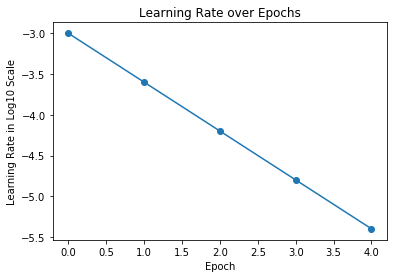

In [ ]:
lr_list = [poly_decay(i) for i in range(nb_epochs)]
plt.scatter(range(nb_epochs), np.log10(lr_list))
plt.plot(np.log10(lr_list))
plt.xlabel('Epoch')
plt.ylabel('Learning Rate in Log10 Scale')
plt.title('Learning Rate over Epochs')

In [ ]:
hist = model.fit_generator(train_generator, 
                           validation_data=val_generator, 
                           epochs=nb_epochs, 
                           callbacks=[chkp, lr_schedule],steps_per_epoch=18381/64,validation_steps=4043/64.0).history
np.savez('inception_dd_history.npz', loss=hist['loss'], acc=hist['acc'], val_loss=hist['val_loss'], val_acc=hist['val_acc'])

Epoch 1/5
288/287 [==============================] - 557s 2s/step - loss: 0.2906 - acc: 0.9087 - val_loss: 1.1244 - val_acc: 0.7747
Epoch 2/5
288/287 [==============================] - 547s 2s/step - loss: 0.0518 - acc: 0.9856 - val_loss: 0.0434 - val_acc: 0.9859
Epoch 3/5
288/287 [==============================] - 545s 2s/step - loss: 0.0210 - acc: 0.9941 - val_loss: 0.0241 - val_acc: 0.9938
Epoch 4/5
213/287 [=====================>........] - ETA: 1:53 - loss: 0.0144 - acc: 0.9958

In [ ]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
train_loss = plt.plot(hist['loss'], label='train loss')
val_loss = plt.plot(hist['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
train_loss = plt.plot(hist['acc'], label='train acc')
val_loss = plt.plot(hist['val_acc'], label='val acc')
plt.legend()
plt.title('Accuracy')

## Predictions

In [ ]:
# val_generator.filenames

In [20]:
val_preds = model.predict_generator(generator=val_generator)

In [21]:
val_preds_class = val_preds.argmax(axis=1)
val_preds_df = pd.DataFrame({'image':val_generator.filenames, 'prediction':val_preds_class})
val_preds_df.head(10)

,image,prediction
0,c0/img_100026.jpg,0
1,c0/img_10012.jpg,0
2,c0/img_1005.jpg,0
3,c0/img_100542.jpg,0
4,c0/img_100656.jpg,0
5,c0/img_100665.jpg,0
6,c0/img_100796.jpg,0
7,c0/img_100824.jpg,0
8,c0/img_101015.jpg,0
9,c0/img_101383.jpg,0


In [22]:
val_generator.class_indices

{'c0': 0,
 'c1': 1,
 'c2': 2,
 'c3': 3,
 'c4': 4,
 'c5': 5,
 'c6': 6,
 'c7': 7,
 'c8': 8,
 'c9': 9}

## Incorrect Predictions

In [23]:
val_incorrect_pred = [i for i in val_preds_df.index.values if int(val_preds_df.image.values[i].split('/')[0][1])!=val_preds_df.prediction.values[i]]
# val_incorrect_pred = [i for i,j in zip(val_preds_df.image.values,val_preds_df.prediction.values) if int(i.split('/')[0][1])!=j]

In [24]:
val_incorrect_pred

[447,
 448,
 449,
 450,
 451,
 452,
 453,
 454,
 455,
 456,
 457,
 458,
 459,
 460,
 461,
 462,
 463,
 464,
 465,
 466,
 467,
 468,
 469,
 470,
 471,
 472,
 473,
 474,
 475,
 476,
 477,
 478,
 479,
 480,
 481,
 482,
 483,
 484,
 485,
 486,
 487,
 488,
 489,
 490,
 491,
 492,
 493,
 494,
 495,
 496,
 497,
 498,
 499,
 500,
 501,
 502,
 503,
 504,
 505,
 506,
 507,
 508,
 509,
 510,
 511,
 512,
 513,
 514,
 515,
 516,
 517,
 518,
 519,
 520,
 521,
 522,
 523,
 524,
 525,
 526,
 527,
 528,
 529,
 530,
 531,
 532,
 533,
 534,
 535,
 536,
 537,
 538,
 539,
 540,
 541,
 542,
 543,
 544,
 545,
 546,
 547,
 548,
 549,
 550,
 551,
 552,
 553,
 554,
 555,
 556,
 557,
 558,
 559,
 560,
 561,
 562,
 563,
 564,
 565,
 566,
 567,
 568,
 569,
 570,
 571,
 572,
 573,
 574,
 575,
 576,
 577,
 578,
 579,
 580,
 581,
 582,
 583,
 584,
 585,
 586,
 587,
 588,
 589,
 590,
 591,
 592,
 593,
 594,
 595,
 596,
 597,
 598,
 599,
 600,
 601,
 602,
 603,
 604,
 605,
 606,
 607,
 608,
 609,
 610,
 611,
 612,
 613

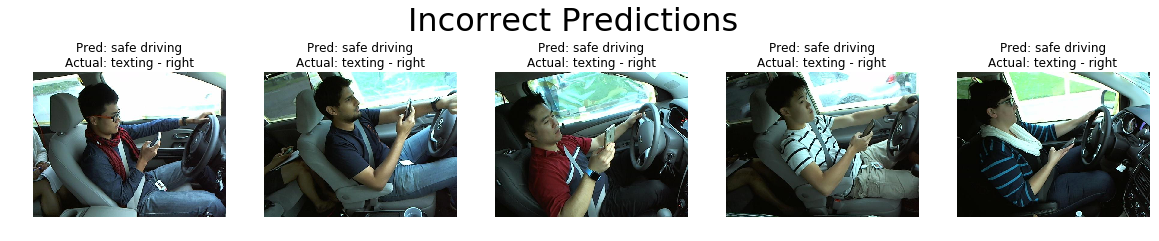

In [25]:
plt.figure(figsize=(20,4))
plt.suptitle("Incorrect Predictions", size=32)
for ix,i in enumerate(val_incorrect_pred):
    img = mpimg.imread("/home/datasets/cse_7321c/distracted_driver/val/"+str(val_preds_df.image[i]))
    plt.subplot(1,5,ix+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Pred: '+class_map['c'+str(val_preds_df.prediction[i])]+'\n'+'Actual: '+class_map[val_preds_df.image[i].split('/')[0]])
    if ix==4:
        break